## ELECTRIC ENERGY DEMAND FORECASTING

### Recurrent Neural Network

The first step is to load all the necessary libraries required for the complete development of data processing and analysis.

In [1]:
import math
import pickle

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers

In [ ]:
pip install tensorflow==2.12 keras==2.12

The entire data download process has been documented step by step in the `downloading_script.ipynb` file, ensuring better organization of each stage. If you haven’t downloaded the data yet, run this script before proceeding.

Once the data is available in a folder named `data`, we can move forward. At this stage, we will load the already pivoted data (structured in the required format) and apply further preprocessing.

In Spain, the time changes twice a year, which must be accounted for in the analysis. To address this, once the affected days are identified, we will perform data interpolation during the affected time interval, ensuring continuity and consistency in the dataset.

In [ ]:
# Load pivoted data
df_pivoted_2020 = pd.read_csv('../data/df_pivoted/df_pivoted_2020.csv')
df_pivoted_2021 = pd.read_csv('../data/df_pivoted/df_pivoted_2021.csv')
df_pivoted_2022 = pd.read_csv('../data/df_pivoted/df_pivoted_2022.csv')
df_pivoted_2023 = pd.read_csv('../data/df_pivoted/df_pivoted_2023.csv')

df_2021 = pd.read_csv('../data/df/df_2021.csv')
df_2022 = pd.read_csv('../data/df/df_2022.csv')
df_2023 = pd.read_csv('../data/df/df_2023.csv')

# Interpolation
indx = df_pivoted_2020[df_pivoted_2020['Date'] == '2020-03-29'].index[0]
df_pivoted_2020.iloc[indx, 24:36] = [df_pivoted_2020.iloc[indx, 23] - i*(df_pivoted_2020.iloc[indx, 23] - df_pivoted_2020.iloc[indx, 36]) / 13 for i in range(1,13)]

indx = df_pivoted_2021[df_pivoted_2021['Date'] == '2021-03-28'].index[0]
df_pivoted_2021.iloc[indx, 24:36] = [df_pivoted_2021.iloc[indx, 23] - i*(df_pivoted_2021.iloc[indx, 23] - df_pivoted_2021.iloc[indx, 36]) / 13 for i in range(1,13)]

indx = df_pivoted_2022[df_pivoted_2022['Date'] == '2022-03-27'].index[0]
df_pivoted_2022.iloc[indx, 24:36] = [df_pivoted_2022.iloc[indx, 23] - i*(df_pivoted_2022.iloc[indx, 23] - df_pivoted_2022.iloc[indx, 36]) / 13 for i in range(1,13)]

indx = df_pivoted_2023[df_pivoted_2023['Date'] == '2023-03-26'].index[0]
df_pivoted_2023.iloc[indx, 24:36] = [df_pivoted_2023.iloc[indx, 23] - i*(df_pivoted_2023.iloc[indx, 23] - df_pivoted_2023.iloc[indx, 36]) / 13 for i in range(1,13)]

# Duplicated data cleaning
null_index = df_pivoted_2020[df_pivoted_2020.isnull().any(axis=1)].index[0]
df_pivoted_2020.iloc[null_index, 253:289] = df_2021[df_2021['Date'] == '2020-12-31']['Real']

null_index = df_pivoted_2021[df_pivoted_2021.isnull().any(axis=1)].index[0]
df_pivoted_2021.iloc[null_index, 253:289] = df_2022[df_2022['Date'] == '2021-12-31']['Real']

null_index = df_pivoted_2022[df_pivoted_2022.isnull().any(axis=1)].index[0]
df_pivoted_2022.iloc[null_index, 253:289] = df_2023[df_2023['Date'] == '2022-12-31']['Real']

Next, we will create the datasets for training and testing.

- **Training set:** This will include data from **2020, 2021, and 2022**.  
- **Test (evaluation) set:** This will consist of data from **2023**.  

Additionally, we will add a new column representing the **day of the week in numerical format**, where Monday is `0`, Tuesday is `1`, and so on until Sunday (`6`). This feature will help the models capture patterns associated with different days of the week.

In [7]:
# Creation of training and testing dataframes
train_df = pd.concat([df_pivoted_2020, df_pivoted_2021, df_pivoted_2022])
train_df = train_df.reset_index().drop(['index'], axis=1)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df['Day_Week'] = train_df['Date'].dt.day_name()
test_df = df_pivoted_2023.drop(df_pivoted_2023.index[-1])
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df['Day_Week'] = test_df['Date'].dt.day_name()

# Convertir la columna 'Date' a tipo datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Codificar la columna 'Day_Week' en variables numéricas
label_encoder = LabelEncoder()
train_df['Day_Week'] = label_encoder.fit_transform(train_df['Day_Week'])
test_df['Day_Week'] = label_encoder.fit_transform(test_df['Day_Week'])

During the research process, I evaluated the results both with and without incorporating the **day of the week** information. The models that included this feature consistently outperformed those that did not.  

Due to the significant improvement in performance, the final version of the model includes this information as a key feature.

In [ ]:
# Version 1 without using the Day of the Week information
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df.drop(['Date', 'Day_Week'], axis=1))
test_scaled = scaler.fit_transform(test_df.drop(['Date', 'Day_Week'], axis=1))

In [ ]:
# Version 2 using the Day of the Week information
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df.drop(['Date'], axis=1))
test_scaled = scaler.fit_transform(test_df.drop(['Date'], axis=1))

Below are several functions used during the development phase to evaluate different versions of the dataset. After extensive testing, I selected **version 1 (v1)** as it yielded the best results.  

However, I am also including previous versions in case they are of interest for further analysis or comparisons.  

This process is crucial to ensure that the dataset is in the correct format for running the algorithms effectively.

In [9]:
# Convert an array of values into a dataset matrix
def create_dataset_v1(dataset, look_back=21):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

def create_dataset_v2(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-29):
		mismo_dia = [(x * 7) + i for x in list(range(4))]
		uno = dataset[mismo_dia[-1]+7-look_back:mismo_dia[-1]+7]
		dos = dataset[mismo_dia]
		a = np.concatenate((uno,dos))
		dataX.append(a)
		dataY.append(dataset[mismo_dia[-1]+7])
	return np.array(dataX), np.array(dataY)

In addition to experimenting with different input data formats, I also evaluated the results using different parameters. One key parameter I tested was **look_back**, which defines the number of past days the model uses to predict the demand for the next day. For example, if a value of 14 is used, the model will base its prediction on the energy demand of the previous 14 days.

In this section, you can experiment with different parameters or functions. For my case, the best results came from **version 1** using a **look_back** value of **21 days**.

In [10]:
look_back = 21
trainX, trainY = create_dataset_v1(train_scaled, look_back)
testX, testY = create_dataset_v1(test_scaled, look_back)

At this stage, we are ready to create the model since we have completed the data cleaning and structuring process. The data is now in the necessary format for use.

The different neural networks that were tested include:

- **Recurrent Neural Networks (RNN)**
  - **GRU (Gated Recurrent Units)**
  - **LSTM (Long Short-Term Memory)**
- **Convolutional Neural Networks (CNN)**

# Recurrent Neural Network

## GRU

To evaluate each model, multiple iterations were performed, testing different parameters and making adjustments to optimize each model until the best possible solution was found.

Below is a comparison of the **GRU model implementation**, where we compare the same parameters with different adjustments. In the second model, we introduced **dropout**, and in the third model, we applied **regularization**.

This comparison highlights the impact of these adjustments on model performance.

In [ ]:
# Simple model implementation
model_GRU = Sequential()
model_GRU.add(GRU(100, input_shape=(21, 289)))
model_GRU.add(Dense(289))
model_GRU.compile(loss='mean_squared_error', optimizer='adam')
model_GRU.fit(trainX, trainY, epochs=100, batch_size=3, verbose=0)

In [16]:
# Model implementation with dropout
model_GRU_dropout = Sequential()
model_GRU_dropout.add(GRU(100, input_shape=(21, 289)))
model_GRU_dropout.add(Dropout(0.2))
model_GRU_dropout.add(Dense(289))
model_GRU_dropout.compile(loss='mean_squared_error', optimizer='adam')
model_GRU_dropout.fit(trainX, trainY, epochs=100, batch_size=3, verbose=0)

In [19]:
# Model implementation with regularization
model_GRU_reg = Sequential()
model_GRU_reg.add(GRU(100, input_shape=(21, 289), kernel_regularizer=l2(0.01)))  # Agrega regularización L2 con una tasa de penalización de 0.01
model_GRU_reg.add(Dense(289))
model_GRU_reg.compile(loss='mean_squared_error', optimizer='adam')
model_GRU_reg.fit(trainX, trainY, epochs=100, batch_size=3, verbose=0)

Once all three models have been created, we can now compare their accuracy. This comparison will allow us to evaluate the performance of each model and determine which one best suits the task at hand.

In [20]:
trainY_inv = scaler.inverse_transform(trainY)
testY_inv = scaler.inverse_transform(testY)

# Make predictions
trainPredict = model_GRU.predict(trainX)
testPredict = model_GRU.predict(testX)

trainPredict_dropout = model_GRU_dropout.predict(trainX)
testPredict_dropout = model_GRU_dropout.predict(testX)

trainPredict_reg = model_GRU_reg.predict(trainX)
testPredict_reg = model_GRU_reg.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

trainPredict_dropout = scaler.inverse_transform(trainPredict_dropout)
testPredict_droput = scaler.inverse_transform(testPredict_dropout)

trainPredict_reg = scaler.inverse_transform(trainPredict_reg)
testPredict_reg = scaler.inverse_transform(testPredict_reg)

# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inv, trainPredict))
testScore = math.sqrt(mean_squared_error(testY_inv, testPredict))

trainScore_dropout = math.sqrt(mean_squared_error(trainY_inv, trainPredict_dropout))
testScore_dropout = math.sqrt(mean_squared_error(testY_inv, testPredict_droput))

trainScore_reg = math.sqrt(mean_squared_error(trainY_inv, trainPredict_reg))
testScore_reg = math.sqrt(mean_squared_error(testY_inv, testPredict_reg))

# Results presentation
print('Results GRU:')
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

print('\nResults GRU with droput:')
print('Train Score: %.2f RMSE' % (trainScore_dropout))
print('Test Score: %.2f RMSE' % (testScore_dropout))

print('\nResults GRU with regularization:')
print('Train Score: %.2f RMSE' % (trainScore_reg))
print('Test Score: %.2f RMSE' % (testScore_reg))

11/11 [==============================] - 0s 9ms/step
Results GRU:
Train Score: 0.50 RMSE
Test Score: 1.04 RMSE

Results GRU with droput:
Train Score: 0.57 RMSE
Test Score: 1.19 RMSE

Results GRU with regularization:
Train Score: 0.90 RMSE
Test Score: 1.47 RMSE


Looking at the results from this first comparison, we can observe that the simplest model yields the best results, both for the training and testing sets. This demonstrates that complexity does not necessarily equate to better performance—this is the proof.

Additionally, the following graph provides a more visual representation of the model's accuracy, where the **orange** line represents the predicted values, and the **blue** line represents the actual values. The graph shows the prediction for **January 1st, 2023**, which is the first prediction made by the model.

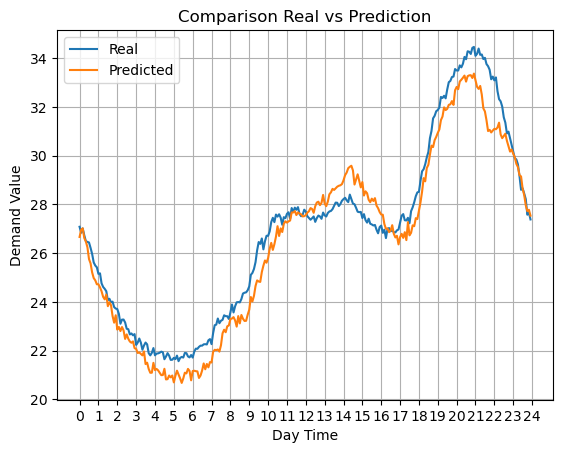

In [24]:
plt.figure()
plt.plot(range(len(testY_inv[0])-1), testY_inv[0][:-1], label='Real')
plt.plot(range(len(testPredict[0])-1), testPredict[0][:-1], label='Predicted')
plt.legend()
ticks = range(0, 289, 12)
labels = range(0, 25)

plt.xticks(ticks, labels)
plt.xlabel('Day Time')
plt.ylabel('Demand Value')
plt.title('Comparison Real vs Prediction')
plt.grid(True)
plt.show()

Next, using the simple model (which gave us the best results), we will perform a couple of nested loops to find the optimal parameters. The goal is to identify the parameter values that yield the best results.

For this experiment, I will test different values of the **neurons_number** parameter: **20**, **50**, and **100**, as well as varying the number of **epochs (num_epochs)** between **50** and **100**.

Finally, I will present the results in a table for a clear comparison.

In [26]:
df_gru = pd.DataFrame(columns=['Neurons', 'Epochs', 'Train RMSE', 'Test RMSE'])

for neurons_number in [20, 50, 100]:
    for num_epochs in [50, 100]:
        model = Sequential()
        model.add(GRU(neurons_number, input_shape=(21, 289)))
        model.add(Dense(289))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(trainX, trainY, epochs=num_epochs, batch_size=1, verbose=0)

        # make predictions
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)
        
        # invert predictions
        trainPredict = scaler.inverse_transform(trainPredict)
        testPredict = scaler.inverse_transform(testPredict)
        
        # calculate root mean squared error
        trainScore = math.sqrt(mean_squared_error(trainY_inv, trainPredict))
        testScore = math.sqrt(mean_squared_error(testY_inv, testPredict))

        new_row = {'Neurons': neurons_number, 'Epochs': num_epochs, 'Train RMSE': trainScore, 'Test RMSE': testScore}
        df_gru = pd.concat([df_gru, pd.DataFrame([new_row])])

df_gru

11/11 [==============================] - 0s 4ms/step


C:\Users\msalg\AppData\Local\Temp\ipykernel_18476\2833803498.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_gru = pd.concat([df_gru, pd.DataFrame([new_row])])


11/11 [==============================] - 0s 10ms/step


,Neurons,Epochs,Train RMSE,Test RMSE
0,20,50,0.750176,1.239420
0,20,100,0.596519,1.210821
0,50,50,0.712727,1.067397
0,50,100,0.653815,1.160970
0,100,50,0.806933,1.229181
0,100,100,0.792718,1.324456


In the table below, we can see the results of different parameter combinations. The best results were obtained with **50 neurons** and **50 epochs**, as this combination yielded the lowest test error.

## LSTM

Initially, we tested different values for **neurons** and **epochs**, using a **batch_size** of **4** to reduce the execution time. As mentioned earlier, after testing various input data combinations, the best results were achieved with data from the **previous 21 days**.

The configuration used for this experiment was as follows:
- **Neurons**: 20, 50, 100
- **Epochs**: 50, 100
- **Batch Size**: 4
- **Input Data**: Last 21 days' data

This setup helped balance computational efficiency with model performance.

In [30]:
df_lstm = pd.DataFrame(columns=['Neurons', 'Epochs', 'Train RMSE', 'Test RMSE'])

for neurons_number in [50, 100, 150]:
    for num_epochs in [50, 100]:
        model = Sequential()
        model.add(LSTM(neurons_number, input_shape=(21, 289)))
        model.add(Dense(289))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(trainX, trainY, epochs=num_epochs, batch_size=4, verbose=0)

        # make predictions
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)
        
        # invert predictions
        trainPredict = scaler.inverse_transform(trainPredict)
        testPredict = scaler.inverse_transform(testPredict)
        
        # calculate root mean squared error
        trainScore = math.sqrt(mean_squared_error(trainY_inv, trainPredict))
        testScore = math.sqrt(mean_squared_error(testY_inv, testPredict))

        new_row = {'Neurons': neurons_number, 'Epochs': num_epochs, 'Train RMSE': trainScore, 'Test RMSE': testScore}
        df_lstm = pd.concat([df_lstm, pd.DataFrame([new_row])])

df_lstm

11/11 [==============================] - 0s 9ms/step


C:\Users\msalg\AppData\Local\Temp\ipykernel_18476\2773134445.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_lstm = pd.concat([df_lstm, pd.DataFrame([new_row])])


11/11 [==============================] - 0s 18ms/step


,Neurons,Epochs,Train RMSE,Test RMSE
0,50,50,0.640436,1.017629
0,50,100,0.659107,1.132402
0,100,50,0.613960,0.985594
0,100,100,0.555482,1.034191
0,150,50,0.575759,1.007233
0,150,100,0.551294,1.038368


Once we've identified the optimal parameters, the next step is to create **10 models** using these parameters. Afterward, we will take the **mean of the predictions** from all models. This process is a form of **bagging** (Bootstrap Aggregating), which helps improve the accuracy of the final predictive model by combining multiple models.

For this experiment, we will use the following parameters:
- **Neurons**: 100
- **Epochs**: 50

By combining multiple models, we aim to reduce variance and improve the robustness of the final predictions.

In [31]:
df_nn = pd.DataFrame(columns=['Neurons', 'Epochs', 'Train RMSE', 'Test RMSE'])
trained_models = []

for _ in range(10):
    model = Sequential()
    model.add(LSTM(100, input_shape=(21, 289)))
    model.add(Dense(289))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=50, batch_size=4, verbose=0)

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    testPredict = scaler.inverse_transform(testPredict)
    
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY_inv, trainPredict))
    testScore = math.sqrt(mean_squared_error(testY_inv, testPredict))
    trained_models.append(model)
    new_row = {'Neurons': 100, 'Epochs': 50, 'Train RMSE': trainScore, 'Test RMSE': testScore}
    df_nn = pd.concat([df_nn, pd.DataFrame([new_row])])
df_nn

11/11 [==============================] - 0s 14ms/step


C:\Users\msalg\AppData\Local\Temp\ipykernel_18476\1741192949.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_nn = pd.concat([df_nn, pd.DataFrame([new_row])])


11/11 [==============================] - 0s 7ms/step


,Neurons,Epochs,Train RMSE,Test RMSE
0,100,50,0.639987,1.017726
0,100,50,0.888302,1.265488
0,100,50,0.716157,1.221479
0,100,50,0.861765,1.015097
0,100,50,0.607740,1.063404
0,100,50,0.597219,1.054012
0,100,50,0.680410,1.030768
0,100,50,0.606073,0.987939
0,100,50,0.698346,1.098863
0,100,50,0.721667,1.241687


After creating and saving the 10 models, the next step is to make predictions using each model. Once we have the individual predictions, we will calculate the final prediction by averaging all the predictions. 

Finally, we will evaluate the accuracy of this final prediction. As we can observe, this method significantly improves the results obtained by the individual models, leading to a much more consistent and reliable outcome.

This process helps leverage the power of ensemble learning to enhance the overall model performance.

In [ ]:
predictions = []
# Generate predictions for each model
for model in trained_models:
    predictions.append(scaler.inverse_transform(model.predict(testX)))

# Calculate the final prediction by averaging the predictions of all models
testPredict = np.mean(predictions, axis=0)
testScore = math.sqrt(mean_squared_error(testY_inv, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

11/11 [==============================] - 0s 6ms/step
Test Score: 0.97 RMSE


To visualize the performance of the ensemble model, we will now display the predictions for the first **16 days** of the year, based on the final model that is the average of the 10 individual models.

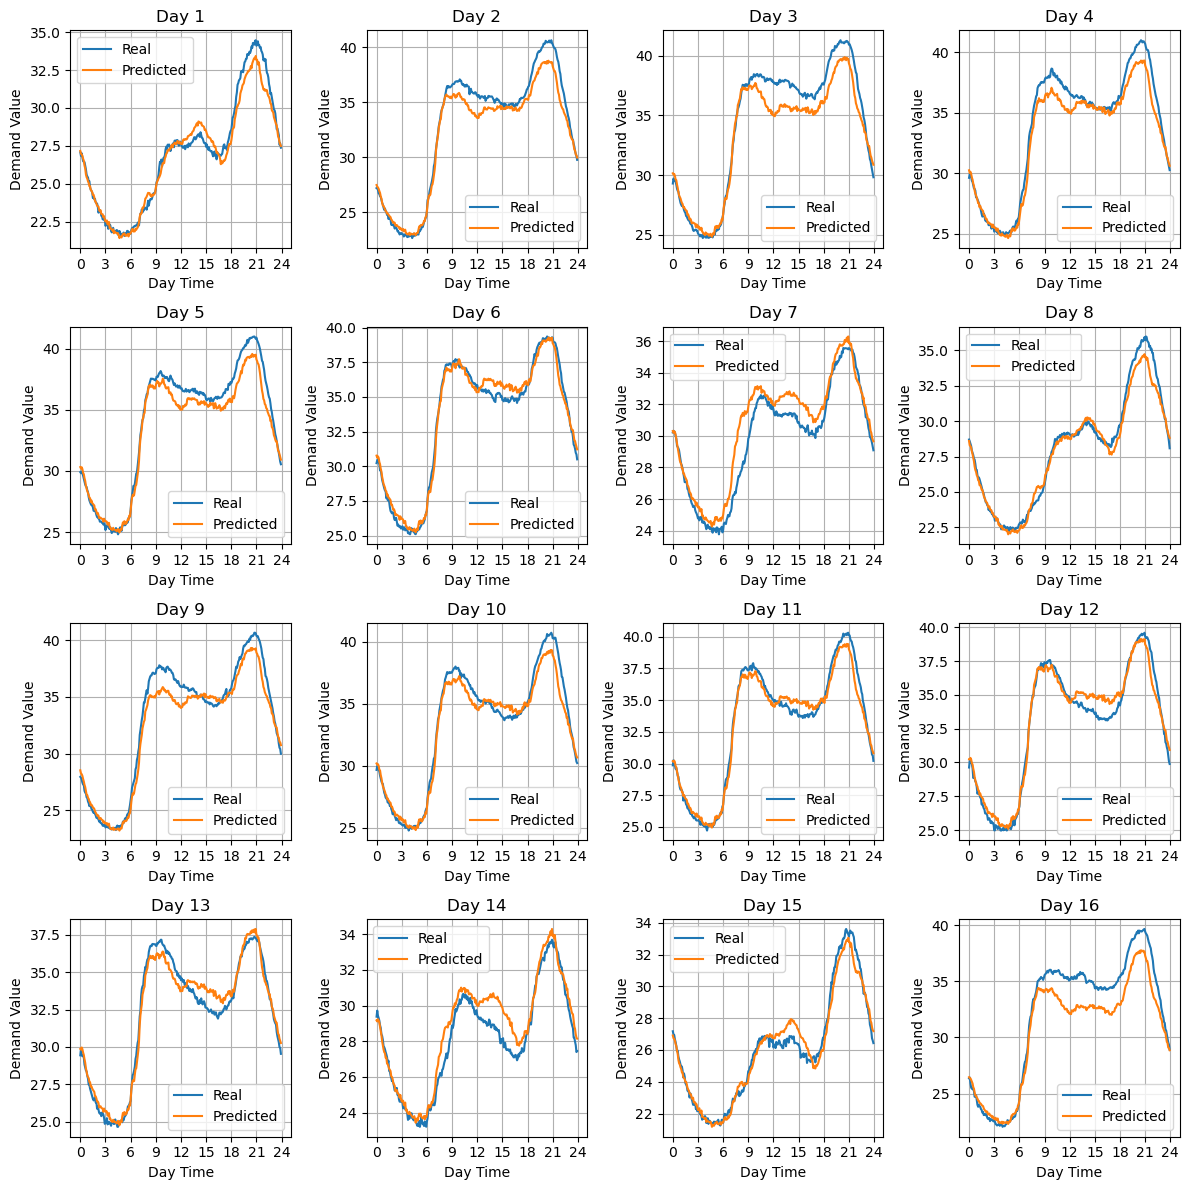

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

# Iterar sobre las filas y columnas de la figura
for i in range(4):
    for j in range(4):
        k = i * 4 + j  # Calcula el índice k para acceder a los datos de cada día
        axs[i, j].plot(range(len(testY_inv[k])-1), testY_inv[k][:-1], label='Real')
        axs[i, j].plot(range(len(testPredict[k])-1), testPredict[k][:-1], label='Predicted')
        axs[i, j].set_xticks(range(0, 289, 36))  # Cada 12 puntos = 1 hora, ajusta según tus datos
        axs[i, j].set_xticklabels(range(0, 25, 3))  # Etiquetas de 0 a 24 horas
        axs[i, j].set_xlabel('Day Time')
        axs[i, j].set_ylabel('Demand Value')
        axs[i, j].set_title(f'Day {k + 1}')
        axs[i, j].grid(True)
        axs[i, j].legend()

plt.tight_layout()  # Ajusta automáticamente la disposición para evitar superposiciones
plt.show()

In the figure, we can observe how the prediction closely matches the actual values for all cases, with an error of just **0.97 GW**. In the generated plots, the **orange line** represents the predicted values, and the **blue line** represents the actual values for those days. I used the **matplotlib** library to create these plots.

Now, let's move on to **model optimization**. There are various techniques for optimizing model parameters, but one of the most reliable and commonly used methods is **GridSearch**, or grid search. This technique allows us to define a set of parameter values that we want the model to test, and it will search for the optimal combination.

For this first step, we will focus on finding the optimal number of neurons, testing three possible values: **50**, **100**, and **150**. Please note that this process may take a considerable amount of computation time.

Since we already know that the **LSTM model** outperforms the **GRU model**, we will directly proceed to optimize the **LSTM** model.

In [ ]:
# Function to create the RNN model
def create_rnn(neurons=100):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(21, 289)))
    model.add(Dense(289))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Create the KerasRegressor model
model = KerasRegressor(build_fn=create_rnn, epochs=100, batch_size=1, verbose=0)

# Define hyperparameters for grid search
param_grid = {'neurons': [50, 100, 150]}  # You can adjust these values as needed

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_result = grid_search.fit(trainX, trainY)

# Display the results
print("Best result: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\msalg\AppData\Local\Temp\ipykernel_18272\4183954754.py:15: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_rnn, epochs=100, batch_size=1, verbose=0)


Mejor resultado: -0.002899 usando {'neurons': 100}


The result from the grid search indicates that the optimal number of neurons is **100**. However, the next step is to optimize all model parameters together: **number of neurons (neurons_number)**, **epochs**, and **batch size (batch_size)**. 

Just like in the previous case, we will test different values for each of these parameters to find the optimal combination for the model.

In [ ]:
# Function to create the LSTM model
def create_lstm(neurons_number=100):
    model = Sequential()
    model.add(LSTM(neurons_number, input_shape=(21, 289)))
    model.add(Dense(289))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Create the KerasRegressor model
model = KerasRegressor(build_fn=create_lstm, verbose=0)

# Define the hyperparameters for the grid search
param_grid = {
    'neurons_number': [100, 150],  # Number of neurons
    'epochs': [100, 150],          # Number of epochs
    'batch_size': [1, 4, 8, 16, 32]  # Batch size options
}

# Perform the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_result = grid_search.fit(trainX, trainY)

# Display the results
print("Best result: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\msalg\AppData\Local\Temp\ipykernel_18272\512625204.py:15: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_lstm, verbose=0)


Mejor resultado: -0.002174 usando {'batch_size': 16, 'epochs': 150, 'neurons_number': 150}


As in the previous case, this process is computationally expensive. After performing the grid search, we find that the **optimal parameter combination** is:

- **Batch Size**: 16
- **Epochs**: 150
- **Neurons Number**: 150

These are the values we will use moving forward for the model.

Just like with the **GRU model**, we tested different variants of the LSTM model to see if the performance could be improved. In this case, we introduced **regularizers** into the model. However, the results were not favorable; the model's performance worsened significantly.

As a result, we will proceed without using regularizers in the model, as they did not contribute to better performance in this case.

In [ ]:
model = Sequential()
model.add(LSTM(150, input_shape=(21, 289),
                              kernel_regularizer=regularizers.l2(0.01),
                              recurrent_regularizer=regularizers.l2(0.01),
                              bias_regularizer=regularizers.l2(0.01)))
model.add(Dense(289, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model.compile(loss='mean_squared_error', optimizer='adam')

# Training the Model with Weighted Errors
model.fit(trainX, trainY, epochs=150, batch_size=16, verbose=0)

# Make predictions on both the training and test sets
trainPredict = model.predict(trainX)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
trainY_inv = scaler.inverse_transform(trainY)
testY_inv = scaler.inverse_transform(testY)
trainScore = math.sqrt(mean_squared_error(trainY_inv, trainPredict))
testScore = math.sqrt(mean_squared_error(testY_inv, testPredict))
print(trainScore)
print(testScore)

11/11 [==============================] - 0s 10ms/step
2.581121410056381
2.9485917312770598


### Boosting + Bagging for Final Model

At this point, we have determined that the **LSTM model** performs the best, and we have also identified the optimal hyperparameters for it. Therefore, we will now use the same **bagging technique** as before, but this time combined with a **boosting process**.

The goal is to iteratively train multiple models, each time incorporating the error from the previous model to improve performance. This allows us to progressively correct the model.

Once we have a large number of models, we will select the models with the best performance (i.e., the lowest error) and compute the average of their predictions. This process will give us the final predictive model.

Below is the code that implements this technique, where we will create 100 models, each trained using the error from the previous model.

In [ ]:
trainY_inv = scaler.inverse_transform(trainY)
testY_inv = scaler.inverse_transform(testY)
# Define a list to store the trained models
boosted_models = []

# Number of boosting models to train
num_boosting_models = 100

# Initialize the weights for the training data
train_weights = np.ones(len(trainY))
df_nn = pd.DataFrame(columns=['Iteration', 'Neurons', 'Epochs', 'batch_size', 'Train RMSE', 'Test RMSE'])
# Iterate through the specified number of boosting models
for i in range(num_boosting_models):
    # Create a new RNN model
    model = Sequential()
    model.add(LSTM(150, input_shape=(21, 289)))
    model.add(Dense(289))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Train the model with weighted data based on errors
    model.fit(trainX, trainY, sample_weight=train_weights, epochs=150, batch_size=16, verbose=0)
    
    # Make predictions on the training and test sets
    trainPredict = model.predict(trainX)
    trainPredict = scaler.inverse_transform(trainPredict)
    testPredict = model.predict(testX)
    testPredict = scaler.inverse_transform(testPredict)
    
    train_errors = np.abs(trainY_inv - trainPredict)
    train_weights = 1 / (np.mean(train_errors, axis=1))
    train_weights /= train_weights.max()
    boosted_models.append(model)
    
    trainScore = math.sqrt(mean_squared_error(trainY_inv, trainPredict))
    testScore = math.sqrt(mean_squared_error(testY_inv, testPredict))
    new_row = {'Iteration': i, 'Neurons': 150, 'Epochs': 150, 'batch_size':16, 'Train RMSE': trainScore, 'Test RMSE': testScore}
    df_nn = pd.concat([df_nn, pd.DataFrame([new_row])])


We now have the 100 models stored in the **boosted_models** variable. The next step is to select the best models. In this case, I have chosen an error threshold, above which I will filter out models. This way, we will obtain a new list containing only the models with an error below the threshold, which in my case is 0.9.

For this process, other selection techniques can be used, and the results can be evaluated accordingly. Additionally, since we created 100 models, it's possible that not all of them meet the desired error level, so more models can be created as needed, and the best ones can be selected afterward.


In [ ]:
final_models = []
for model in boosted_models:
    testPredict = model.predict(testX)
    testPredict = scaler.inverse_transform(testPredict)
    testScore = math.sqrt(mean_squared_error(testY_inv, testPredict))
    
    if testScore < 0.9:
        final_models.append(model)

At this point, we now have our selected models from which we can generate predictions and later calculate the average.

To save them permanently locally and be able to load them easily, we will use the pickle library to save the models, allowing us to load them whenever we need. In order to save and load them this way, we will need version 2.12 of both Keras and TensorFlow, as later versions may cause errors.

In [ ]:
modelos_rnn =  final_models.copy()

# Save the models in a file using pickle
with open('../models/final_models.pkl', 'wb') as f:
    pickle.dump(modelos_rnn, f)

Now we will load the model from the local storage to ensure that it has been saved correctly.

In [ ]:
with open('../models/final_models.pkl', 'rb') as f:
    modelos_rnn_cargados = pickle.load(f)

Once we have saved all our models that make up the final predictive model, we can proceed. First, let's take a look at the error of each model in our selected model set.

In [ ]:
scores = []
# Generate predictions for each model
for model in modelos_rnn_cargados:
    testPredict = scaler.inverse_transform(model.predict(testX))
    testScore = math.sqrt(mean_squared_error(testY_inv, testPredict))
    scores.append(testScore)
    print('Test Score: %f RMSE' % (testScore))

11/11 [==============================] - 2s 28ms/step
Test Score: 0.880764 RMSE
11/11 [==============================] - 2s 36ms/step
Test Score: 0.882776 RMSE
11/11 [==============================] - 2s 20ms/step
Test Score: 0.877262 RMSE
11/11 [==============================] - 2s 20ms/step
Test Score: 0.879356 RMSE
11/11 [==============================] - 2s 40ms/step
Test Score: 0.881957 RMSE
11/11 [==============================] - 2s 27ms/step
Test Score: 0.878529 RMSE
11/11 [==============================] - 1s 25ms/step
Test Score: 0.879021 RMSE
11/11 [==============================] - 1s 18ms/step
Test Score: 0.855446 RMSE
11/11 [==============================] - 1s 15ms/step
Test Score: 0.872622 RMSE
11/11 [==============================] - 2s 28ms/step
Test Score: 0.871418 RMSE


In my case, I have chosen the 10 models that yielded the best accuracy, although both the selection criteria and the number of models making up the final model can be adjusted.

In the next step, let's see what our overall accuracy is by averaging the predictions from all our selected models (bagging).

In [ ]:
predictions = []
# Generate predictions for each model
for model in modelos_rnn_cargados:
    predictions.append(scaler.inverse_transform(model.predict(testX)))

# Calculate the final prediction using the prediction average of all the models
testPredict = np.mean(predictions, axis=0)
testScore = math.sqrt(mean_squared_error(testY_inv, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

11/11 [==============================] - 0s 20ms/step
Test Score: 0.84 RMSE


We can see that thanks to this technique, we have achieved a significant improvement in the model's error.

To fully validate our models, we will use other metrics to calculate different types of errors, thus providing more meaningful metrics in addition to RMSE (Root Mean Squared Error). We will calculate all of these for each of our models.

In [ ]:
# List to store the errors of each model
errors = []

# Function to calculate e_day (%), handling divisions by zero
def calculate_e_day_percentage(y_true, y_pred):
    with np.errstate(divide='ignore', invalid='ignore'):
        percentage_errors = np.abs((y_true - y_pred) / y_true) * 100
        percentage_errors = np.where(np.isfinite(percentage_errors), percentage_errors, 0)
    return np.mean(percentage_errors)

# Function to calculate e_day^FEMSE
def calculate_e_day_FEMSE(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

# Function to calculate σ²_e,day
def calculate_variance_e_day(y_true, y_pred):
    errors = y_true - y_pred
    return np.var(errors)

# Generate predictions for each model and calculate the errors
for model in modelos_rnn_cargados:
    testPredict = scaler.inverse_transform(model.predict(testX))
    
    rmse = math.sqrt(mean_squared_error(testY_inv, testPredict))
    e_day_percentage = calculate_e_day_percentage(testY_inv, testPredict)
    e_day_FEMSE = calculate_e_day_FEMSE(testY_inv, testPredict)
    variance_e_day = calculate_variance_e_day(testY_inv, testPredict)
    
    errors.append({
        'Model': model.name,  # Assuming each model has a 'name' attribute
        'RMSE': rmse,
        'e_day (%)': e_day_percentage,
        'e_day^FEMSE': e_day_FEMSE,
        'σ²_e,day': variance_e_day
    })

# Create a pandas DataFrame to display the results
errors_df = pd.DataFrame(errors)

# Display the table with all the errors
errors_df

11/11 [==============================] - 0s 31ms/step


,Model,RMSE,e_day (%),e_day^FEMSE,"σ²_e,day"
0,sequential_22,0.880764,2.258586,0.880764,0.765993
1,sequential_41,0.882776,2.266808,0.882776,0.762282
2,sequential_91,0.877262,2.255064,0.877262,0.767987
3,sequential_94,0.879356,2.221031,0.879356,0.761365
4,sequential_95,0.881957,2.282612,0.881957,0.740331
5,sequential_106,0.878529,2.232302,0.878529,0.767307
6,sequential_129,0.879021,2.239451,0.879021,0.764685
7,sequential_30,0.855446,2.150178,0.855446,0.727336
8,sequential_35,0.872622,2.218112,0.872622,0.761354
9,sequential_54,0.871418,2.201729,0.871418,0.748490


In the table above, we can see the values of the different metrics for each model.

The next step will be to calculate these metrics for the final predictive model (the one obtained by averaging the other models) and compare them with the individual results.

In [ ]:
predictions = []
# Generate predictions for each model
for model in modelos_rnn_cargados:
    predictions.append(scaler.inverse_transform(model.predict(testX)))

# Calculate the final prediction by averaging the predictions of all models
testPredict = np.mean(predictions, axis=0)

# Function to calculate e_day (%)
def calculate_e_day_percentage(y_true, y_pred):
    with np.errstate(divide='ignore', invalid='ignore'):
        percentage_errors = np.abs((y_true - y_pred) / y_true) * 100
        percentage_errors = np.where(np.isfinite(percentage_errors), percentage_errors, 0)
    return np.mean(percentage_errors)


# Function to calculate e_day^FEMSE
def calculate_e_day_FEMSE(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

# Function to calculate σ²_e,day
def calculate_variance_e_day(y_true, y_pred):
    errors = y_true - y_pred
    return np.var(errors)

# Calculate the metrics for the predictions
e_day_percentage = calculate_e_day_percentage(testY_inv, testPredict)
e_day_FEMSE = calculate_e_day_FEMSE(testY_inv, testPredict)
variance_e_day = calculate_variance_e_day(testY_inv, testPredict)

print(f'e_day (%): {e_day_percentage:.2f}')
print(f'e_day^FEMSE: {e_day_FEMSE:.2f}')
print(f'σ²_e,day: {variance_e_day:.6f}')

11/11 [==============================] - 0s 20ms/step
e_day (%): 2.10
e_day^FEMSE: 0.84
σ²_e,day: 0.690185


We can observe that all metrics have improved, so this will be our final prediction for the electricity demand.

Finally, we present the predictions for the first 16 days of the year made with our final predictive model.

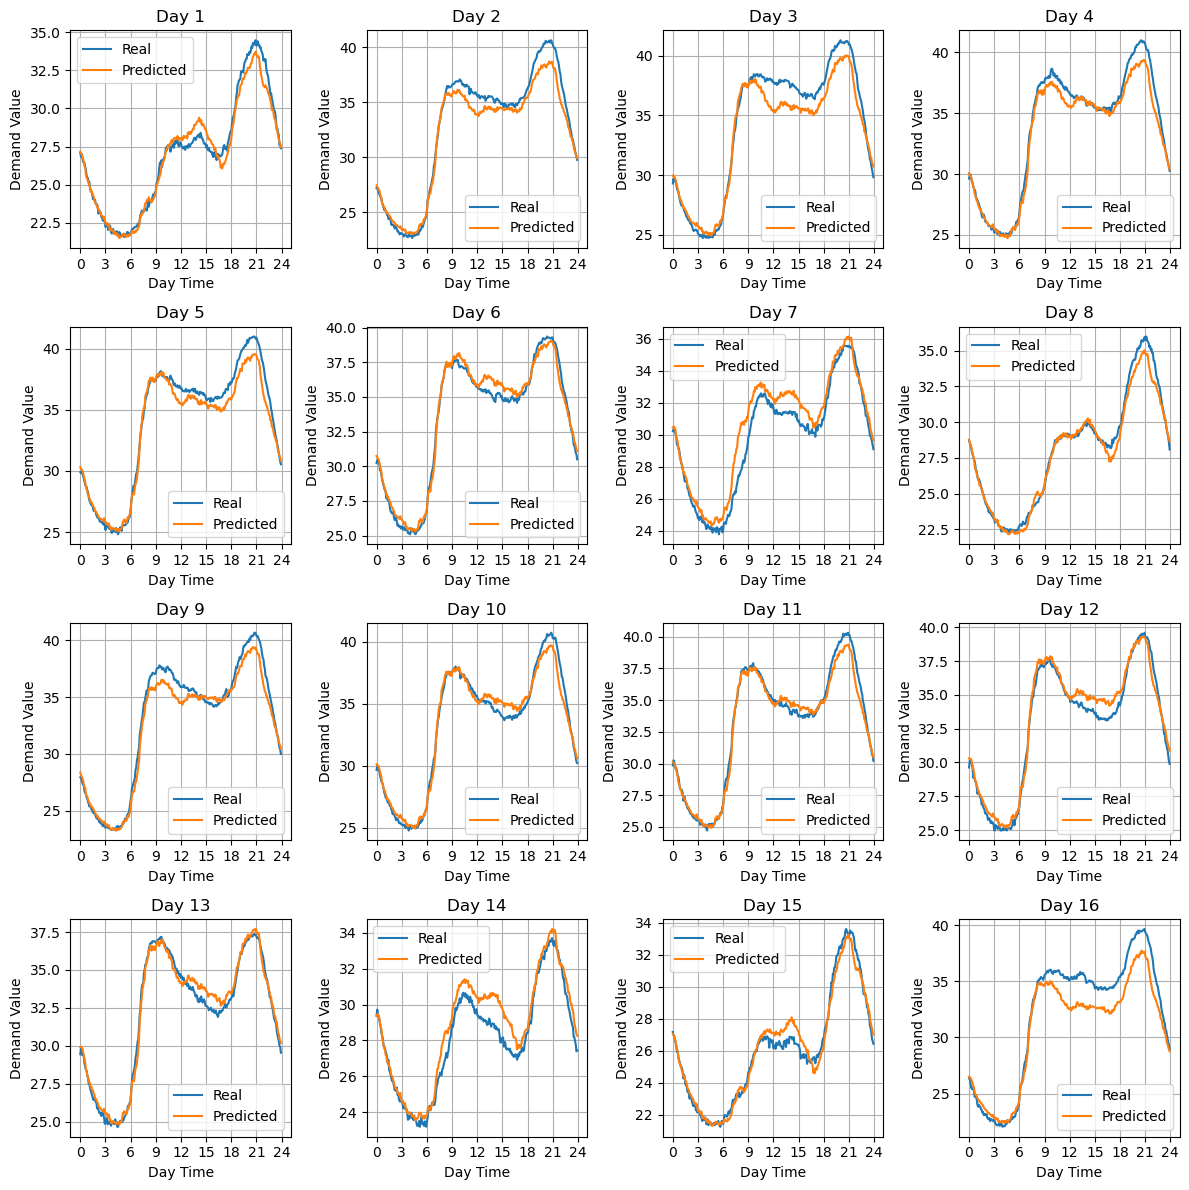

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

# Iterate over the rows and columns of the figure
for i in range(4):
    for j in range(4):
        k = i * 4 + j  # Calculate the index k to access the data for each day
        axs[i, j].plot(range(len(testY_inv[k])-1), testY_inv[k][:-1], label='Real')
        axs[i, j].plot(range(len(testPredict[k])-1), testPredict[k][:-1], label='Predicted')
        axs[i, j].set_xticks(range(0, 289, 36))  # Every 12 points = 1 hour, adjust according to your data
        axs[i, j].set_xticklabels(range(0, 25, 3))  # Labels from 0 to 24 hours
        axs[i, j].set_xlabel('Day Time')
        axs[i, j].set_ylabel('Demand Value')
        axs[i, j].set_title(f'Day {k + 1}')
        axs[i, j].grid(True)
        axs[i, j].legend()

plt.tight_layout()  # Automatically adjusts the layout to avoid overlaps
plt.show()